Linear algebra
==============

Linear algebra is a fast and efficient means of solving silent substitution problems.

Basic example
-------------

************************************************************
*************** Silent Substitution Problem ****************
************************************************************
Device: BCGAR (8-bit, linear)
Observer: ColorimetricObserver(age=32, field_size=10)
Ignoring: ['rh']
Silencing: ['mc', 'lc', 'mel']
Targeting: ['sc']
Target contrast: [ 0.3]
Background: [0.5, 0.5, 0.5, 0.5, 0.5]


The background settings are: [127, 127, 127, 127, 127]
The modulation settings are: [245, 56, 129, 132, 83]


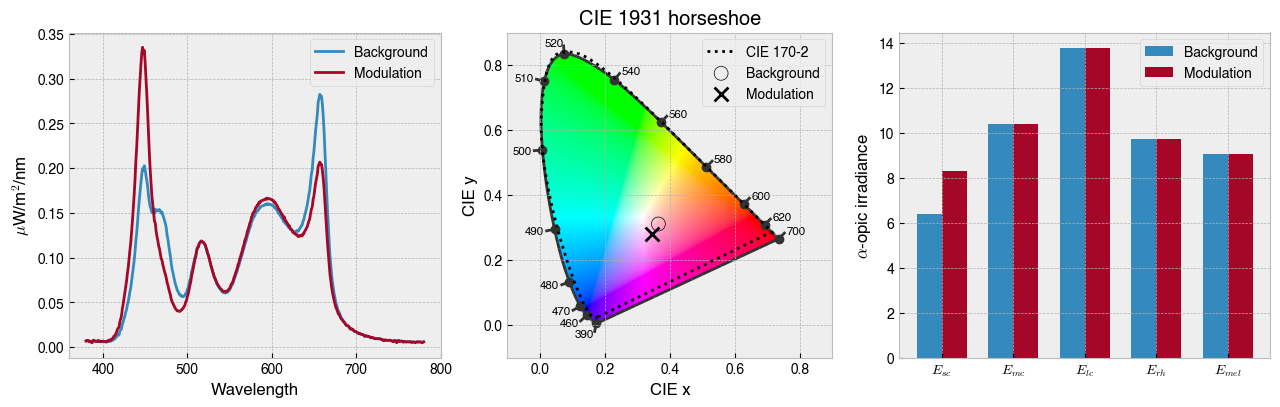

In [51]:
from pysilsub.problems import SilentSubstitutionProblem as SSP

# Instantiate the problem class for a 5-primary system
ssp = SSP.from_package_data('BCGAR')

# Define problem
ssp.ignore = ['rh']
ssp.target = ['sc']
ssp.silence = ['mc', 'lc', 'mel']
ssp.background = [.5] * ssp.nprimaries
ssp.target_contrast = .3
ssp.print_problem()

# Find solution
solution = ssp.linalg_solve()

# Plot solution
fig = ssp.plot_solution(solution)

# Show device settings
print(f'The background settings are: {ssp.w2s(ssp.background)}')
print(f'The modulation settings are: {ssp.w2s(solution)}')


Worked example
--------------

Here's what just happened. 

For a background spectrum we take the mixture of all primaries at half-max power, $\alpha_{bg} = [.5 \ .5 \ .5 \ .5 \ .5]$. We then use this to compute the matrix $P_{bg}$, whose rows contain the spectral power distributions for each primary component of the background spectrum. 

Note that in this case we are not summing the predicted spectra as we'll be doing matrix algebra involving the individual primaries.

In [112]:
a_bg = [.5, .5, .5, .5, .5]
P_bg = ssp.predict_multiprimary_spd(a_bg, nosum=True)
P_bg.T

Wavelength,380,381,382,383,384,385,386,387,388,389,...,771,772,773,774,775,776,777,778,779,780
Primary,,,,,,,,,,,,,,,,,,,,,
0,0.001098,0.001134,0.000991,0.001091,0.000879,0.000891,0.001021,0.000812,0.001010,0.001188,...,0.000595,0.000620,0.000643,0.000634,0.000629,0.000625,0.000577,0.000516,0.000605,0.000600
1,0.000856,0.000933,0.000838,0.000828,0.000745,0.000710,0.000804,0.000523,0.000840,0.000927,...,0.000465,0.000517,0.000513,0.000519,0.000556,0.000533,0.000525,0.000398,0.000539,0.000559
2,0.001115,0.001191,0.001198,0.001231,0.001003,0.000958,0.001071,0.000718,0.001226,0.001268,...,0.000667,0.000768,0.000741,0.000678,0.000777,0.000710,0.000693,0.000562,0.000733,0.000826
3,0.001842,0.002067,0.001945,0.001945,0.001673,0.001608,0.001715,0.001290,0.001955,0.002015,...,0.002439,0.002435,0.002404,0.002383,0.002361,0.002349,0.002305,0.002146,0.002114,0.002350
4,0.001736,0.002040,0.001812,0.002044,0.001556,0.001693,0.001622,0.001239,0.001834,0.002078,...,0.001141,0.001277,0.001299,0.001251,0.001467,0.001355,0.001301,0.001093,0.001240,0.001354


Next, we need to compute the matrix of $a$-opic irradiances:

$A = P_{bg} \cdot S_{a}$

where the columns of $S_{a}$ are the photoreceptor action spectra of the observer.

In [100]:
from pysilsub.CIE import get_CIES026_action_spectra

S_a = get_CIES026_action_spectra()
S_a

,sc,mc,lc,rh,mel
Wavelength,,,,,
380,0.0,0.000000,0.000000,5.890000e-04,9.181600e-04
381,0.0,0.000000,0.000000,6.650000e-04,1.045600e-03
382,0.0,0.000000,0.000000,7.520000e-04,1.178600e-03
383,0.0,0.000000,0.000000,8.540000e-04,1.322800e-03
384,0.0,0.000000,0.000000,9.720000e-04,1.483800e-03
...,...,...,...,...,...
776,0.0,0.000002,0.000024,1.730000e-07,2.550000e-08
777,0.0,0.000002,0.000023,1.640000e-07,2.420000e-08
778,0.0,0.000002,0.000021,1.550000e-07,2.290000e-08


The dot product of these matrices gives $A$

In [106]:
A = S_a.T.dot(P_bg)
A

Primary,0,1,2,3,4
sc,3.580009,2.453689,0.211358,0.095264,0.057067
mc,0.627573,1.355843,3.573256,4.683028,0.156777
lc,0.435727,0.873636,2.915142,8.686473,0.853310
rh,1.730730,2.965132,3.638927,1.288265,0.076642
mel,2.094721,3.520715,2.841600,0.509312,0.069365


Now, given a set of scaling coefficients for the primaries, $\alpha_{sc}=\left[p_1\ p_{2\ }p_{3\ }p_{4\ }p_5\right]$, the forward model predicts that the output modulation $\beta=\left[sc\ mc\ lc\ rh\ mel\right]$ is $\beta= \alpha_{sc}A$.

To invert this process, we calculate $\alpha_{sc}=\beta A^{-1}$, which yields the desired scaling coefficients that must be added to the primary weights for the background in order to produce the desired output modulation $\beta$.

In [113]:
import numpy as np
import pandas as pd

# Calculate inverse of A
A1 = pd.DataFrame(
    np.linalg.inv(A.values),
    A.columns, 
    A.index)
A1

,sc,mc,lc,rh,mel
Primary,,,,,
0,0.473797,-0.159332,-0.001803,0.993080,-1.104764
1,-0.279487,0.340021,-0.037472,-1.654925,1.750941
2,-0.002424,-0.286409,0.015329,1.342032,-1.022070
3,0.026572,0.502356,-0.059770,-0.855885,0.523675
4,-0.218010,-4.402157,1.767262,5.315177,-3.067724


In [114]:
# Requested modulation for S-cones
requested_contrast = .2

# sc, mc, lc, rh, mel
b = np.array([requested_contrast, 0., 0., 0., 0.])

# Scale requested contrasts to percentage of background units
b = A.sum(axis=1).mul(b)

# Calculate the scaling coefficients
a_sc = A1.dot(b) / 2
a_sc

Primary
0    0.303106
1   -0.178799
2   -0.001551
3    0.016999
4   -0.139469
dtype: float64

Following on from above, $\alpha_{mod} = \alpha_{bg} + \alpha_{sc}$.

In [115]:
a_mod = (a_bg + a_sc).to_list()
a_mod

[0.8031061259025292,
 0.32120125937804056,
 0.4984491198072997,
 0.5169994543850375,
 0.36053050404907117]

Obviously, these values need to be between zero and one for the solution to be valid, which in this case they are. As before, we can visualise the solution.

The background settings are: [127, 127, 127, 127, 127]
The modulation settings are: [204, 81, 127, 131, 91]


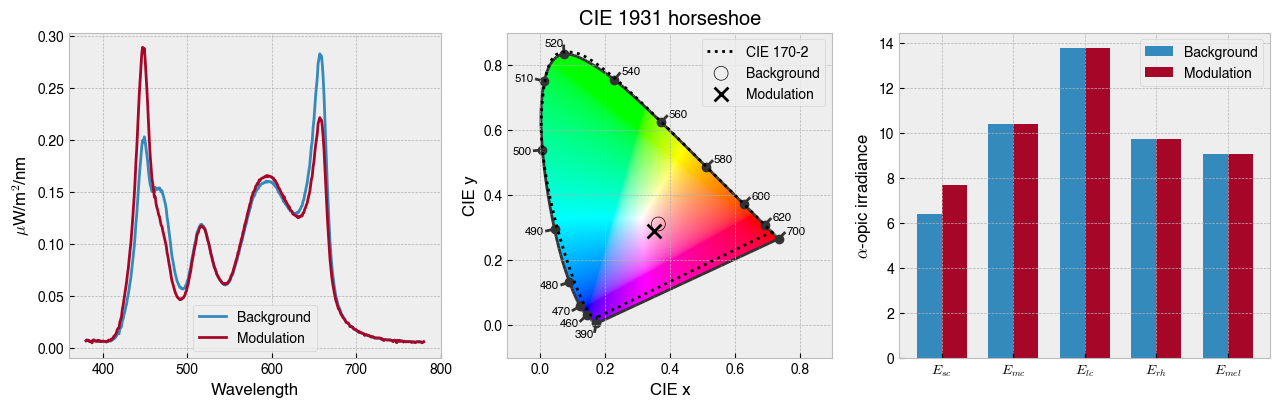

In [116]:
# Plot the solutution
result_fig = ssp.plot_solution(a_mod)

# Show device settings
print(f'The background settings are: {ssp.w2s(a_bg)}')
print(f'The modulation settings are: {ssp.w2s(a_mod)}')

Contrast modulations
--------------------

Multiprimary devices with good linearity, sufficient bit depth and rapid spectral switching capabilities may be used to present temporal modulations of photoreceptor-targeted contrast. Such stimuli have helped to shed light on how the pupil responds to input from different photoreceptors as a function of time (e.g., [Barrionuevo et al., 2016](https://jov.arvojournals.org/article.aspx?articleid=2565122); [Spitschan et al., 2014](https://www.pnas.org/doi/10.1073/pnas.1400942111)). 

To make contrast modulations, first define a stimulus profile with a sampling frequency in line with the switching capability of the stimulation device. In this case, its a 1 Hz sinusoid with 50 samples per cycle.


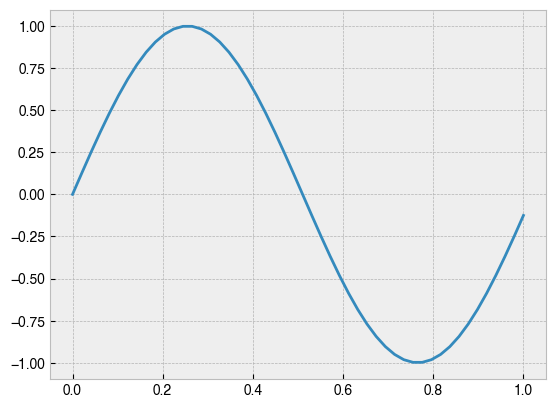

In [117]:
import matplotlib.pyplot as plt

from pysilsub import waves 

duration = 1  # s
frequency = 1  # Hz
sampling_frequency = 50  # Hz

stimulus_profile = waves.make_stimulus_waveform(
    frequency=frequency,
    duration=duration,
    sampling_frequency=sampling_frequency
)

time = np.linspace(0, duration, len(stimulus_profile))

plt.plot(time, stimulus_profile)

Now, define a problem. Here we define the background spectrum as all primaries at half-max power so we can maximise bidirectional contrast. Then we say that we want to ignore rods, minimize contrast on M-cones, L-cones and melanopsin, and modulate the S-cones.

In [118]:
# Load some example data for a 10-primary system
ssp = SSP.from_package_data('STLAB_1_York')

ssp.background = [.5] * ssp.nprimaries
ssp.ignore = ['rh']
ssp.silence = ['mc', 'lc', 'mel']
ssp.target = ['sc']
ssp.print_problem()

************************************************************
*************** Silent Substitution Problem ****************
************************************************************
Device: STLAB_1 (binocular, left eye)
Observer: ColorimetricObserver(age=32, field_size=10)
Ignoring: ['rh']
Silencing: ['mc', 'lc', 'mel']
Targeting: ['sc']
Target contrast: None
Background: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]




Next, choose a peak contrast value that is known to be in gamut and solve for each point in the stimulus profile. The algebraic approach is well suited here as it guarantees a linear uni-directional scaling of the primaries and is less computationally expensive than optimisation. 

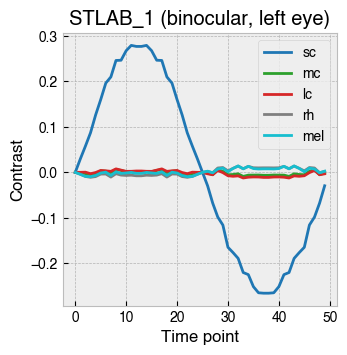

In [119]:
peak_contrast = .3  # Known to be within gamut
solutions = []
for point in stimulus_profile:
    ssp.target_contrast = point * peak_contrast
    solutions.append(ssp.linalg_solve())

# Plot the modulation
_ = ssp.plot_contrast_modulation(solutions)    

Plotting the forward projection of contrast for each solution in this case reveals a smooth S-cone modulation with little contrast splatter on the other photoreceptors.

Finally, convert the solutions to settings compatible with the native resolution of the stimulation device.

In [120]:
device_settings = [ssp.w2s(s) for s in solutions]
device_settings = pd.DataFrame(device_settings, index=time)
device_settings.index.name = 'time'
with pd.option_context('display.max_rows', 10):
    print(device_settings)

             0     1     2     3     4     5     6     7     8     9
time                                                                
0.000000  2047  2047  2047  2047  2047  2047  2047  2047  2047  2047
0.020408  2194  2194  2021  1977  1924  2033  2118  2034  1971  2014
0.040816  2338  2339  1995  1907  1804  2019  2189  2020  1897  1982
0.061224  2477  2480  1971  1840  1687  2006  2257  2008  1824  1951
0.081633  2610  2613  1947  1776  1576  1993  2322  1996  1756  1921
...        ...   ...   ...   ...   ...   ...   ...   ...   ...   ...
0.918367  1360  1356  2169  2377  2622  2113  1712  2110  2402  2201
0.938776  1484  1481  2147  2318  2518  2101  1772  2098  2338  2173
0.959184  1617  1614  2123  2254  2407  2088  1837  2086  2270  2143
0.979592  1756  1755  2099  2187  2290  2075  1905  2074  2197  2112
1.000000  1900  1900  2073  2117  2170  2061  1976  2060  2123  2080

[50 rows x 10 columns]


Now you just need to tell the stimulation device to set the primary inputs to these values at the specified timepoints and it will produce the S-cone modulation shown above. 

Note that with this method one can also modulate multiple photoreceptors together.

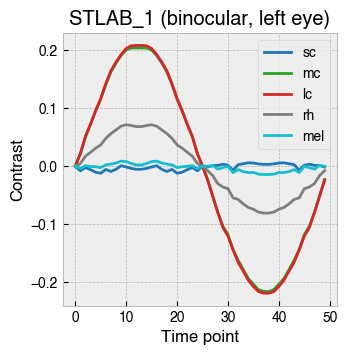

In [121]:
ssp.ignore = ['rh']
ssp.silence = ['sc', 'mel']
ssp.target = ['mc', 'lc']

peak_contrast = .2  # Known to be within gamut
solutions = []
for point in stimulus_profile:
    ssp.target_contrast = point * peak_contrast
    solutions.append(ssp.linalg_solve())
    
# Plot the modulation
_ = ssp.plot_contrast_modulation(solutions)

We can even modulate photoreceptors in counterphase.

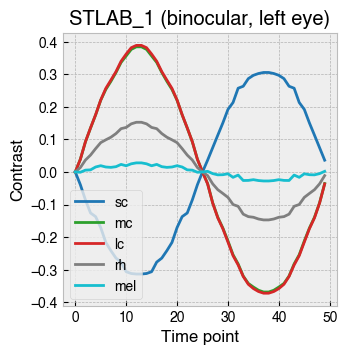

In [122]:
ssp.ignore = ['rh']
ssp.silence = ['mel']
ssp.target = ['sc', 'mc', 'lc']

peak_contrast = .35  # Known to be within gamut
solutions = []
for point in stimulus_profile:
    c = point * peak_contrast
    ssp.target_contrast = [-c, c, c]
    solutions.append(ssp.linalg_solve())

# Plot the modulation
_ = ssp.plot_contrast_modulation(solutions)